## Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem
from sklearn.linear_model import LogisticRegressionCV
import torch

seed = 1234
np.random.seed(seed) 

from scipy.ndimage import rotate

## Loading and Scaling Data

In [32]:
# 1. Setup the paths
base_path = "." 
images_folder = os.path.join(base_path, "images")
csv_file = os.path.join(base_path, "legend.csv")

# 2. Read CSV file
df = pd.read_csv(csv_file)

# Lists to store our data
data = []   # This will become X
labels = [] # This will become y

# Define a fixed size for images. For example, MINST is 28*28, here we do 64*64 
IMG_SIZE = 64

print("Loading images... this might take a moment.")

# 3. Loop through the CSV and load images
for index, row in df.iterrows():
    img_name = row['image']
    emotion = row['emotion']

    img_path = os.path.join(images_folder, img_name)

    # Check if file actually exists to avoid errors
    if os.path.exists(img_path):
        # Load image in Grayscale (usually sufficient for emotion detection)
        # If you want color, remove the second argument.
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img_array is not None:
            # Resize the image (Crucial step!)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
            # Flatten the image
            # This converts the 2D image (64x64) into a 1D row of numbers (4096,)
            # This matches the format your professor used for X
            flat_array = new_array.flatten()
            
            data.append(flat_array)
            labels.append(emotion)

# 4. Convert to Numpy Arrays (X and y)
X = np.array(data)
y = np.array(labels)

print("Data loaded successfully!")
print(f"Features (X) shape: {X.shape}") # Should be (Number of images, 4096)
print(f"Labels (y) shape: {y.shape}")    # Should be (Number of images,)


Loading images... this might take a moment.
Data loaded successfully!
Features (X) shape: (13690, 4096)
Labels (y) shape: (13690,)


## **Augmentation Toolkit**
- Build reusable helpers for diverse geometric/photometric transforms.
- Plan to oversample only the training split so each emotion reaches the same count as the majority class (typically happiness/neutral).

In [33]:
def apply_random_transforms(img, rng):
    """Apply a diverse set of randomized geometric and photometric transforms."""
    augmented = img.astype(np.float32)

    if rng.random() < 0.5:
        augmented = np.fliplr(augmented)

    angle = rng.uniform(-15, 15)
    augmented = rotate(augmented, angle=angle, reshape=False, mode='reflect')

    if rng.random() < 0.6:
        alpha = rng.uniform(0.85, 1.25)
        beta = rng.uniform(-12, 12)
        augmented = alpha * augmented + beta

    if rng.random() < 0.3:
        ksize = int(rng.choice([3, 5]))
        augmented = cv2.GaussianBlur(augmented, (ksize, ksize), 0)
    elif rng.random() < 0.3:
        blurred = cv2.GaussianBlur(augmented, (3, 3), 0)
        augmented = np.clip(augmented + (augmented - blurred), 0, 255)

    if rng.random() < 0.4:
        noise = rng.normal(0, 8, augmented.shape)
        augmented = augmented + noise

    if rng.random() < 0.4:
        tx = int(rng.integers(-4, 5))
        ty = int(rng.integers(-4, 5))
        transform_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        augmented = cv2.warpAffine(
            augmented,
            transform_matrix,
            (IMG_SIZE, IMG_SIZE),
            borderMode=cv2.BORDER_REFLECT101
        )

    augmented = np.clip(augmented, 0, 255)
    return augmented.astype(np.float32)


def balance_classes_with_augmentation(X, y, target_count=None, rng_seed=seed):
    """Augment only the provided split until every class reaches target_count samples."""
    X = np.asarray(X)
    y = np.asarray(y)

    class_counts = pd.Series(y).value_counts().sort_index()
    anchor_counts = [class_counts.get(label, class_counts.max()) for label in ("happiness", "neutral")]
    default_target = max(anchor_counts + [class_counts.max()])
    target_count = target_count or default_target

    rng = np.random.default_rng(rng_seed)
    new_samples = []
    new_labels = []

    for label, count in class_counts.items():
        needed = int(max(0, target_count - count))
        if needed == 0:
            continue

        label_indices = np.where(y == label)[0]
        for _ in range(needed):
            base_idx = rng.choice(label_indices)
            base_img = X[base_idx].reshape(IMG_SIZE, IMG_SIZE)
            augmented_img = apply_random_transforms(base_img, rng)
            new_samples.append(augmented_img.flatten())
            new_labels.append(label)

    if new_samples:
        augmented_X = np.vstack((X.astype(np.float32), np.array(new_samples, dtype=np.float32)))
        augmented_y = np.concatenate((y, np.array(new_labels)))
    else:
        augmented_X = X.astype(np.float32)
        augmented_y = y

    augmented_counts = pd.Series(augmented_y).value_counts().sort_index()
    return augmented_X, augmented_y, class_counts, augmented_counts, target_count

In [34]:
def summarize_counts(labels, title):
    counts = pd.Series(labels).value_counts().sort_index()
    print(f"=== {title} ===")
    print(counts)
    print(f"Total samples: {counts.sum():,}\n")
    return counts


base_counts = summarize_counts(y, "Original dataset distribution")
anchor_target = max(
    base_counts.get("happiness", base_counts.max()),
    base_counts.get("neutral", base_counts.max())
)
print(f"Anchor target per class (matching happiness/neutral): {anchor_target}")

=== Original dataset distribution ===
anger         252
contempt        9
disgust       208
fear           21
happiness    5696
neutral      6868
sadness       268
suprise       368
Name: count, dtype: int64
Total samples: 13,690

Anchor target per class (matching happiness/neutral): 6868


In [35]:
def plot_class_counts(before_counts, after_counts, title):
    labels = sorted(set(before_counts.index).union(after_counts.index))
    before = [before_counts.get(lbl, 0) for lbl in labels]
    after = [after_counts.get(lbl, 0) for lbl in labels]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(12, 5))
    plt.bar(x - width / 2, before, width, label="Before")
    plt.bar(x + width / 2, after, width, label="After")
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Samples")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def preview_random_augmentations(X, y, label=None, samples=3, rng_seed=seed):
    rng = np.random.default_rng(rng_seed)
    if label is None:
        label = rng.choice(np.unique(y))

    label_indices = np.where(y == label)[0]
    if len(label_indices) == 0:
        print(f"Label '{label}' not found in the provided data.")
        return

    plt.figure(figsize=(samples * 3, 4))
    for i in range(samples):
        idx = rng.choice(label_indices)
        original_img = X[idx].reshape(IMG_SIZE, IMG_SIZE)
        augmented_img = apply_random_transforms(original_img, rng)

        plt.subplot(2, samples, i + 1)
        plt.imshow(original_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} original")

        plt.subplot(2, samples, samples + i + 1)
        plt.imshow(augmented_img, cmap="gray")
        plt.axis("off")
        plt.title(f"{label} augmented")

    plt.suptitle(f"Random augmentations for '{label}'")
    plt.tight_layout()
    plt.show()

Previewing augmentation effects for minority label: contempt


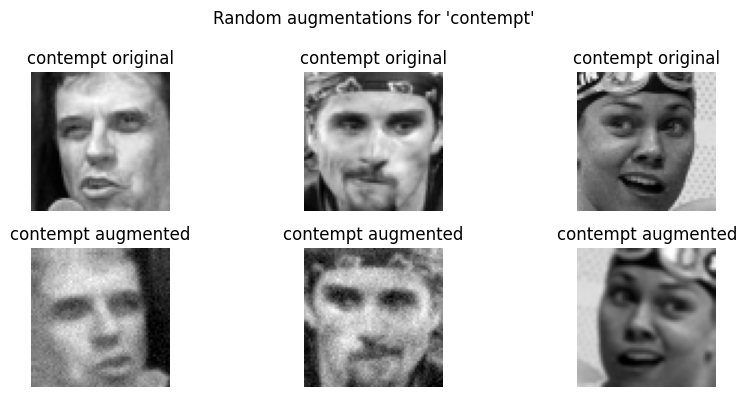


Previewing augmentation effects for common label: happiness


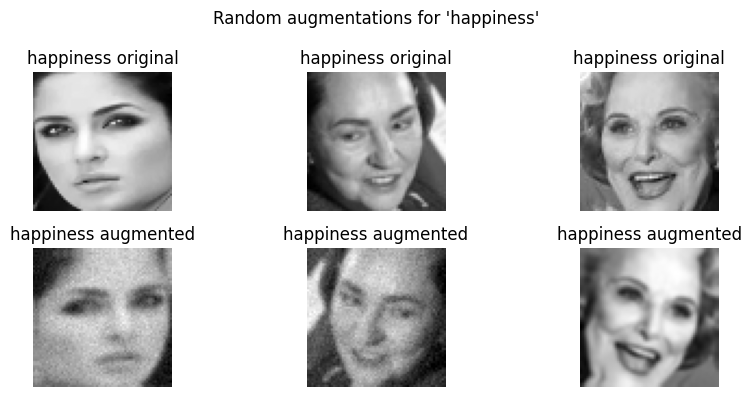

In [36]:
rare_label = base_counts.idxmin()
common_label = "happiness" if "happiness" in base_counts.index else base_counts.idxmax()

print(f"Previewing augmentation effects for minority label: {rare_label}")
preview_random_augmentations(X, y, label=rare_label, samples=3)

print(f"\nPreviewing augmentation effects for common label: {common_label}")
preview_random_augmentations(X, y, label=common_label, samples=3)

In [37]:
needed_per_label = base_counts.apply(lambda c: max(0, anchor_target - c)).sort_values(ascending=False)
print("=== Samples needed per label to match anchor target ===")
print(needed_per_label)
print("\nThese counts determine how many synthetic examples each class will receive once we augment the training split.")

=== Samples needed per label to match anchor target ===
contempt     6859
fear         6847
disgust      6660
anger        6616
sadness      6600
suprise      6500
happiness    1172
neutral         0
Name: count, dtype: int64

These counts determine how many synthetic examples each class will receive once we augment the training split.


### Balanced augmentation strategy

- All images remain grayscale 64×64, but we now apply a richer transform palette: random flips, ±15° rotations, brightness/contrast jitter, Gaussian blur or sharpening, small translations, and gentle Gaussian noise. Each call produces a unique variant rather than deterministic duplicates.
- We only augment the **training split**. Validation and test images stay untouched so performance estimates remain honest.
- Every class is oversampled until it matches the anchor size defined by the most common label (`happiness` or `neutral` in this dataset). Rare emotions therefore receive more synthetic samples than already-balanced ones.
- Augmented samples are concatenated with the original training set before scaling; `StandardScaler` is still fit exclusively on that (now larger) training data and then applied to validation/test splits.
- Helper utilities report class counts before/after augmentation and let us visualize random augmented examples for any label to ensure the transforms look reasonable.

## Training Data Splitting

=== Data Split Summary ===
Training set:   9,583 samples (70.0%)
Validation set: 2,053 samples (15.0%)
Test set:       2,054 samples (15.0%)
Total:          13,690 samples

=== Training split counts before augmentation ===
anger         176
contempt        6
disgust       146
fear           15
happiness    3987
neutral      4807
sadness       188
suprise       258
Name: count, dtype: int64

Target per class for training augmentation: 4807

=== Training split counts after augmentation ===
anger        4807
contempt     4807
disgust      4807
fear         4807
happiness    4807
neutral      4807
sadness      4807
suprise      4807
Name: count, dtype: int64
Total augmented training samples: 38,456 (added 28,873)


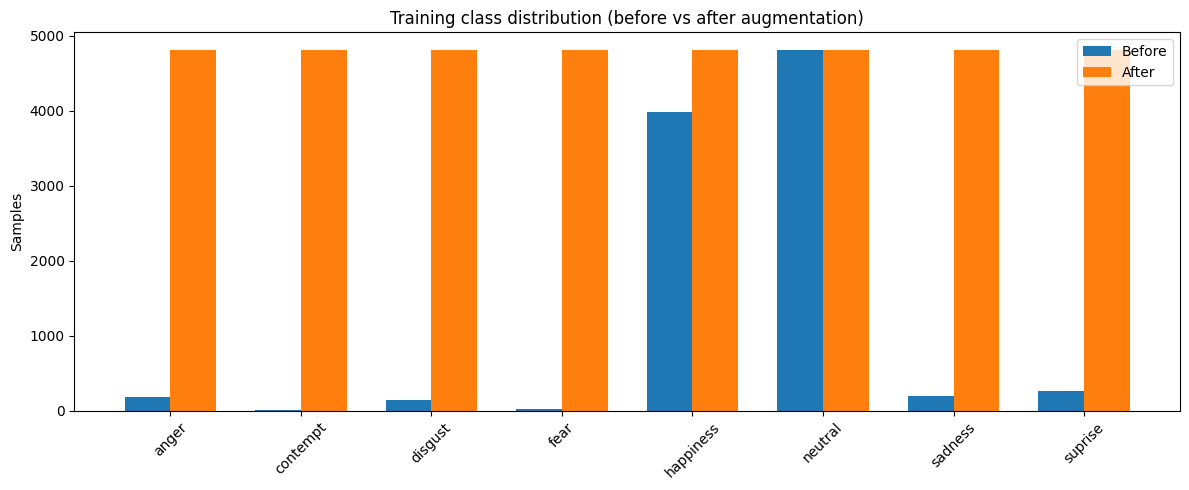

Scaling complete. Validation/test sets remain unaugmented to avoid leakage.


In [38]:
# Split strategy: 70% train, 15% validation, 15% test
# Using stratified sampling to maintain class proportions (for imbalanced "disgust" class)

# First split: 70% train, 30% temp (which will become val + test)
X_tr, X_temp, y_tr, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=seed,
    shuffle=True,
    stratify=y
)

# Second split: Split the 30% temp into 50/50 -> 15% val, 15% test
X_val, X_te, y_val, y_te = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=seed,
    shuffle=True,
    stratify=y_temp
)

print("=== Data Split Summary ===")
print(f"Training set:   {X_tr.shape[0]:,} samples ({X_tr.shape[0] / len(X) * 100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0] / len(X) * 100:.1f}%)")
print(f"Test set:       {X_te.shape[0]:,} samples ({X_te.shape[0] / len(X) * 100:.1f}%)")
print(f"Total:          {len(X):,} samples\n")

train_counts_before = pd.Series(y_tr).value_counts().sort_index()
print("=== Training split counts before augmentation ===")
print(train_counts_before)

train_target = max(
    train_counts_before.get("happiness", train_counts_before.max()),
    train_counts_before.get("neutral", train_counts_before.max())
)
print(f"\nTarget per class for training augmentation: {train_target}")

X_tr_bal, y_tr_bal, before_counts, after_counts, _ = balance_classes_with_augmentation(
    X_tr,
    y_tr,
    target_count=train_target,
    rng_seed=seed
)

print("\n=== Training split counts after augmentation ===")
print(after_counts)
print(f"Total augmented training samples: {X_tr_bal.shape[0]:,} (added {X_tr_bal.shape[0] - X_tr.shape[0]:,})")

plot_class_counts(before_counts, after_counts, "Training class distribution (before vs after augmentation)")

# Scaling - fit ONLY on the augmented training data, transform all sets
scaler = StandardScaler()
scaler.fit(X_tr_bal)
X_tr = scaler.transform(X_tr_bal)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)
y_tr = y_tr_bal

print("Scaling complete. Validation/test sets remain unaugmented to avoid leakage.")

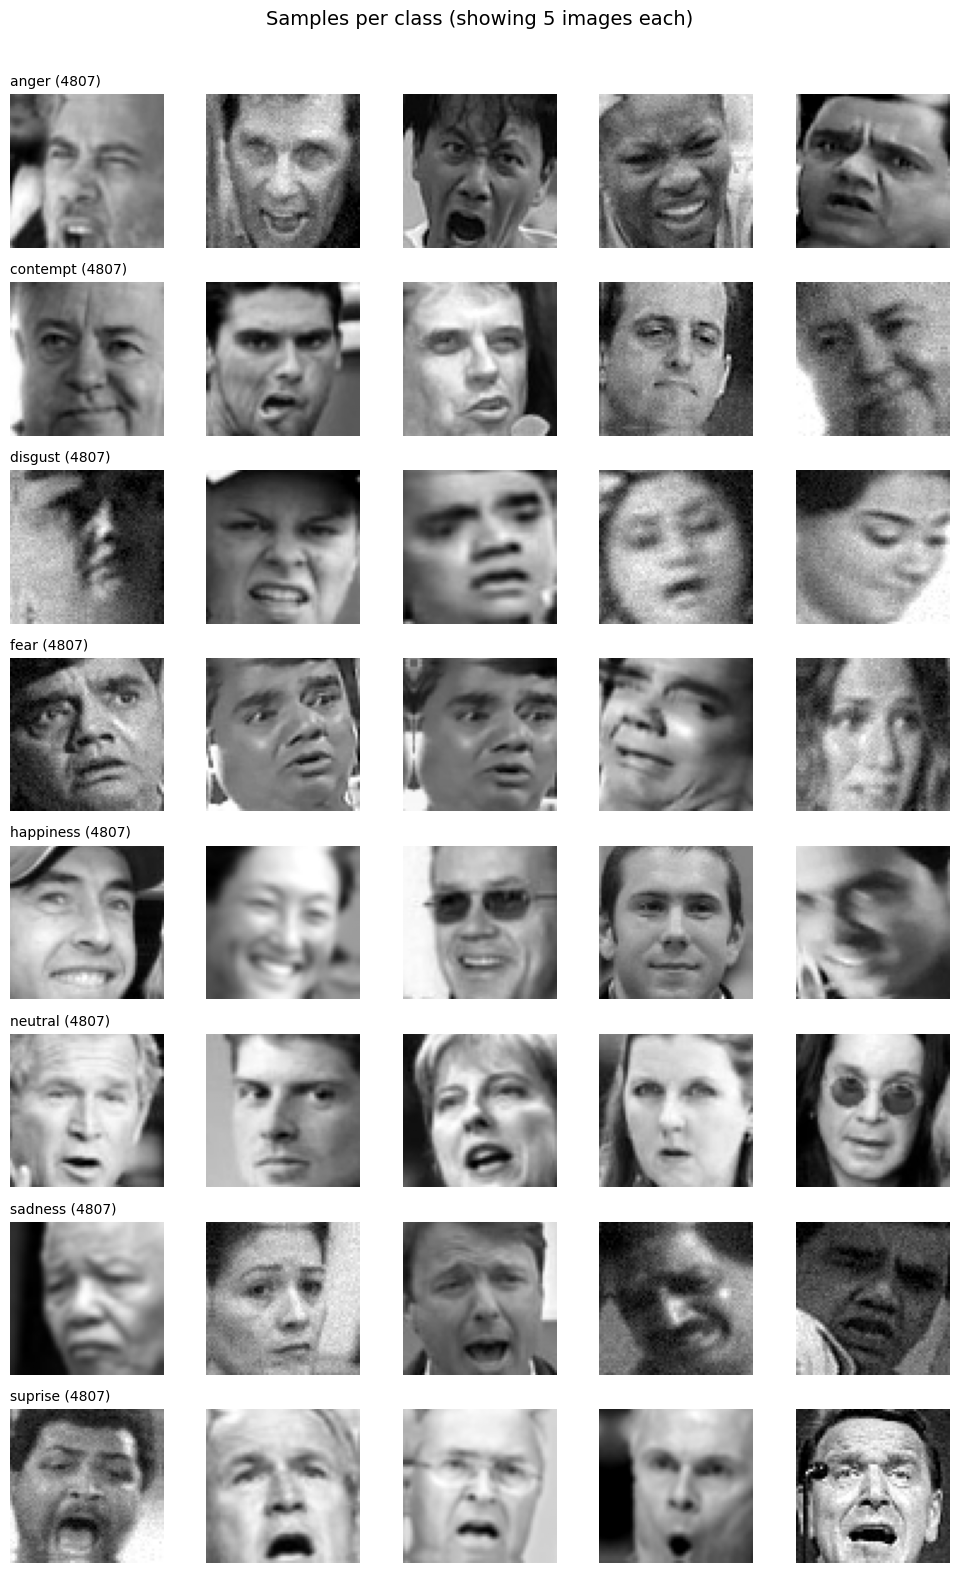

In [39]:
def plot_samples_per_class(X, y, classes=None, samples_per_class=5, seed=seed):
    """
    Plot a grid of sample images for each class (rows = class, cols = samples).
    X: flattened images (N, 4096)
    y: labels (N,)
    classes: list-like class names to show (default: all unique labels)
    samples_per_class: number of samples to show per class
    """
    classes = list(classes) if classes is not None else sorted(np.unique(y))
    rng = np.random.default_rng(seed)

    n_classes = len(classes)
    cols = samples_per_class
    rows = n_classes

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.0, rows * 2.0))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    for i, cls in enumerate(classes):
        idxs = np.where(y == cls)[0]
        if idxs.size == 0:
            for j in range(cols):
                ax = axes[i, j]
                ax.axis("off")
            continue

        if idxs.size >= cols:
            sel = rng.choice(idxs, size=cols, replace=False)
        else:
            sel = rng.choice(idxs, size=cols, replace=True)

        for j in range(cols):
            ax = axes[i, j]
            img = X[sel[j]].reshape((IMG_SIZE, IMG_SIZE))
            # If the X is scaled rather than uint8, normalize for display
            if np.issubdtype(img.dtype, np.floating):
                # map to 0-1 for grayscale display
                if img.max() > img.min():
                    img_disp = (img - img.min()) / (img.max() - img.min())
                else:
                    img_disp = img
                ax.imshow(img_disp, cmap="gray")
            else:
                ax.imshow(img, cmap="gray", vmin=0, vmax=255)
            ax.axis("off")
            if j == 0:
                ax.set_title(f"{cls} ({len(idxs)})", fontsize=10, loc="left")

    plt.suptitle(f"Samples per class (showing {samples_per_class} images each)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Preview 5 images per class from the original dataset
labels_unique = sorted(np.unique(y_tr_bal))
plot_samples_per_class(X_tr_bal, y_tr_bal, classes=labels_unique, samples_per_class=5)